In [2]:
from absbox.report_parser.china import *
import toolz as tz
from lenses import lens
import dateparser
from more_itertools import transpose,unzip
import pandas as pd
from dateutil import relativedelta
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')

#### 资产池 & 摊还 预处理

粘贴现金流归集表

In [6]:
t = '''
归集日期 期初剩余本金 回收本金 回收利息 期末剩余本金
2024/5/31 4,660,000,751.07 216,165,873.90 5,429,316.15 4,443,834,877.17
2024/6/30 4,443,834,877.17 216,102,529.82 9,718,841.41 4,227,732,347.35
2024/7/31 4,227,732,347.35 216,284,438.83 9,415,469.85 4,011,447,908.52
2024/8/31 4,011,447,908.52 216,386,135.47 9,110,984.02 3,795,061,773.05
2024/9/30 3,795,061,773.05 216,257,371.33 8,805,627.39 3,578,804,401.72
2024/10/31 3,578,804,401.72 215,955,194.69 8,500,014.86 3,362,849,207.03
2024/11/30 3,362,849,207.03 214,438,307.92 8,194,101.20 3,148,410,899.11
2024/12/31 3,148,410,899.11 206,558,597.42 7,890,064.00 2,941,852,301.69
2025/1/31 2,941,852,301.69 193,868,773.61 7,604,087.19 2,747,983,528.08
2025/2/28 2,747,983,528.08 186,505,673.82 7,346,034.99 2,561,477,854.26
2025/3/31 2,561,477,854.26 186,472,629.23 7,104,570.64 2,375,005,225.03
2025/4/30 2,375,005,225.03 186,173,640.00 6,863,133.24 2,188,831,585.03
2025/5/31 2,188,831,585.03 185,947,910.61 6,622,937.34 2,002,883,674.42
2025/6/30 2,002,883,674.42 185,473,419.27 6,383,661.54 1,817,410,255.15
2025/7/31 1,817,410,255.15 185,625,057.52 6,146,609.19 1,631,785,197.63
2025/8/31 1,631,785,197.63 185,706,884.34 5,908,201.49 1,446,078,313.29
2025/9/30 1,446,078,313.29 185,755,325.89 5,668,500.63 1,260,322,987.40
2025/10/31 1,260,322,987.40 185,821,633.73 5,427,428.08 1,074,501,353.67
2025/11/30 1,074,501,353.67 158,833,762.71 5,184,980.48 915,667,590.96
2025/12/31 915,667,590.96 132,494,776.30 4,944,924.92 783,172,814.66
2026/1/31 783,172,814.66 80,929,412.60 4,708,250.97 702,243,402.06
2026/2/28 702,243,402.06 36,122,766.76 4,483,764.74 666,120,635.30
2026/3/31 666,120,635.30 36,334,994.79 4,269,171.16 629,785,640.51
2026/4/30 629,785,640.51 36,547,485.23 4,053,236.63 593,238,155.28
2026/5/31 593,238,155.28 36,759,488.08 3,835,945.39 556,478,667.20
2026/6/30 556,478,667.20 36,950,041.82 3,617,306.67 519,528,625.38
2026/7/31 519,528,625.38 37,118,550.35 3,397,456.77 482,410,075.03
2026/8/31 482,410,075.03 37,299,564.39 3,176,587.17 445,110,510.64
2026/9/30 445,110,510.64 37,457,646.16 2,954,601.43 407,652,864.48
2026/10/31 407,652,864.48 37,637,000.32 2,731,679.03 370,015,864.16
2026/11/30 370,015,864.16 33,479,477.98 2,507,680.35 336,536,386.18
2026/12/31 336,536,386.18 29,312,600.98 2,307,714.69 307,223,785.20
2027/1/31 307,223,785.20 20,803,250.15 2,131,002.28 286,420,535.05
2027/2/28 286,420,535.05 12,840,946.15 1,998,685.41 273,579,588.90
2027/3/31 273,579,588.90 12,930,325.78 1,909,305.78 260,649,263.12
2027/4/30 260,649,263.12 13,020,335.02 1,819,296.54 247,628,928.10
2027/5/31 247,628,928.10 13,110,978.23 1,728,653.37 234,517,949.87
2027/6/30 234,517,949.87 13,195,930.52 1,637,371.14 221,322,019.35
2027/7/31 221,322,019.35 13,285,679.18 1,545,495.02 208,036,340.17
2027/8/31 208,036,340.17 13,375,829.14 1,452,984.97 194,660,511.03
2027/9/30 194,660,511.03 13,459,130.09 1,359,841.28 181,201,380.94
2027/10/31 181,201,380.94 13,542,336.73 1,266,101.19 167,659,044.21
2027/11/30 167,659,044.21 13,281,080.96 1,171,769.83 154,377,963.25
2027/12/31 154,377,963.25 12,931,866.33 1,079,156.92 141,446,096.92
2028/1/31 141,446,096.92 12,271,052.86 988,851.38 129,175,044.06
2028/2/29 129,175,044.06 11,658,789.57 903,162.07 117,516,254.49
2028/3/31 117,516,254.49 11,740,174.18 821,777.23 105,776,080.31
2028/4/30 105,776,080.31 11,820,317.46 739,817.44 93,955,762.85
2028/5/31 93,955,762.85 11,902,842.97 657,292.28 82,052,919.88
2028/6/30 82,052,919.88 11,976,634.08 574,184.28 70,076,285.80
2028/7/31 70,076,285.80 12,056,819.46 490,549.29 58,019,466.34
2028/8/31 58,019,466.34 12,141,023.57 406,345.31 45,878,442.77
2028/9/30 45,878,442.77 12,217,738.42 321,547.19 33,660,704.35
2028/10/31 33,660,704.35 12,293,388.61 236,200.66 21,367,315.74
2028/11/30 21,367,315.74 10,177,274.42 150,315.05 11,190,041.32
2028/12/31 11,190,041.32 7,656,825.13 79,077.99 3,533,216.19
2029/1/31 3,533,216.19 3,533,216.19 25,094.93 -

'''

In [30]:
## JSD

### 现金流预处理
xx = tz.pipe(t
       ,lambda x: x.replace("-","0.0")
       ,removeComma
       ,lambda x: x.strip().split("\n")
       ,splitSpace
       ,lambda xs: xs[1:]
       ,lambda xs: xs & lens.Each()[0].modify(lambda y:dateparser.parse(y))
       ,lambda xs: xs & lens.Each().Fork(lens[1],lens[2],lens[3],lens[4]).modify(float)
       ,lambda xs: list(transpose(xs))
       ,lambda xs: list(transpose([xs[0],xs[4],xs[2],xs[3]]))
       ,lambda xs: xs & lens.Each().modify(list)
       )
xx

cashflowTable = tz.pipe(xx
       ,lambda xs: xs & lens.Each()[0].modify(lambda y: y.strftime("%Y-%m-%d")) 
       )

In [31]:
## A1 固定摊还预处理
s = \
    '''
“支付日” 目标余额(元) 还款金额(元)
2024/9/26 1,600,000,000 -
2024/10/26 1,600,000,000 -
2024/11/26 1,600,000,000 -
2024/12/26 1,408,000,000 192,000,000
2025/1/26 1,232,000,000 176,000,000
2025/2/26 1,056,000,000 176,000,000
2025/3/26 880,000,000 176,000,000
2025/4/26 704,000,000 176,000,000
2025/5/26 528,000,000 176,000,000
2025/6/26 352,000,000 176,000,000
2025/7/26 176,000,000 176,000,000
2025/8/26 - 176,000,000
    '''

In [32]:
xy = tz.pipe(s
       ,lambda x: x.replace("-","0.0")
       ,removeComma
       ,lambda x: x.strip().split("\n")
       ,splitSpace
       ,lambda xs: xs[1:]
       ,lambda xs: xs & lens.Each()[0].modify(lambda y:dateparser.parse(y))
       ,lambda xs: xs & lens.Each()[0].modify(lambda y: y.strftime("%Y-%m-%d")) 
       ,lambda xs: xs & lens.Each().Fork(lens[1],lens[2]).modify(float)
       )
xy

amortSchedule = [ _[:-1] for _ in xy ]
amortSchedule

[['2024-09-26', 1600000000.0],
 ['2024-10-26', 1600000000.0],
 ['2024-11-26', 1600000000.0],
 ['2024-12-26', 1408000000.0],
 ['2025-01-26', 1232000000.0],
 ['2025-02-26', 1056000000.0],
 ['2025-03-26', 880000000.0],
 ['2025-04-26', 704000000.0],
 ['2025-05-26', 528000000.0],
 ['2025-06-26', 352000000.0],
 ['2025-07-26', 176000000.0],
 ['2025-08-26', 0.0]]

In [16]:
A1 = pd.DataFrame(data= xy).set_index(0)
A1.index.names = ['Date']
A1 = A1[[1,2]].rename(columns={1:"余额",2:"还款"})
A1["A1-利息"] = A1["余额"] * 0.02/12
A1["A1-利息"] = A1["A1-利息"].shift(periods=1,fill_value=2_666_666.667)
A1

,余额,还款,A1-利息
Date,,,
2024-09-26,1600000000.000,0.000,2666666.667
2024-10-26,1600000000.000,0.000,2666666.667
2024-11-26,1600000000.000,0.000,2666666.667
2024-12-26,1408000000.000,192000000.000,2666666.667
2025-01-26,1232000000.000,176000000.000,2346666.667
2025-02-26,1056000000.000,176000000.000,2053333.333
2025-03-26,880000000.000,176000000.000,1760000.000
2025-04-26,704000000.000,176000000.000,1466666.667
2025-05-26,528000000.000,176000000.000,1173333.333


In [17]:
raw = pd.DataFrame(data= xx)
raw[0] = [ (_ + relativedelta.relativedelta(months=1)).replace(day=26) for _ in raw[0]]
raw = raw.set_index(0)
raw.index.names = ['Date']
poolInflow = raw[[1,2,3]].rename(columns={2:"本金",3:"利息",1:"余额"})
poolInflow["税后利息"] = poolInflow["利息"] * (1-0.0326)
poolInflow["服务费用"] = poolInflow["余额"] * 0.00025/12
poolInflow["资产池流入-合计"] = poolInflow["本金"]+poolInflow["税后利息"] - poolInflow["服务费用"]
poolInflow.head()

,余额,本金,利息,税后利息,服务费用,资产池流入-合计
Date,,,,,,
2024-06-26,4443834877.170,216165873.900,5429316.150,5252320.444,92579.893,221325614.450
2024-07-26,4227732347.350,216102529.820,9718841.410,9402007.180,88077.757,225416459.243
2024-08-26,4011447908.520,216284438.830,9415469.850,9108525.533,83571.831,225309392.531
2024-09-26,3795061773.050,216386135.470,9110984.020,8813965.941,79063.787,225121037.624
2024-10-26,3578804401.720,216257371.330,8805627.390,8518563.937,74558.425,224701376.842


In [18]:
jointTbl = poolInflow.join(A1[["还款","A1-利息"]]).fillna(0)#.head(16)
#计算 buffer
#jointTbl['buffer'] = jointTbl['合计'] - jointTbl['A1-本息合计']
#jointTbl.drop(columns=['利息'])

jointTbl["A2-余额"]= 0 #2460000000
jointTbl["A2-利息"]= 0 
jointTbl["A2-本金"]= 0 
jointTbl['循环购买账户'] = 0
jointTbl['可供A2本金余额'] = 0
jointTbl['可供A1本金余额'] = 0

A2Balance = 2460000000
buyAccount = 0
drawAmt = 0
cashReserve = 37_280_006.01

for index, row in jointTbl.iterrows():
    if index <= dateparser.parse("2024-08-26"):
        buyAccount += jointTbl["资产池流入-合计"].at[index]
        jointTbl['循环购买账户'].at[index] = buyAccount
        continue
        
    jointTbl["A2-余额"].at[index] = A2Balance
    jointTbl["A2-利息"].at[index] = A2Balance * 0.03 / 12
    if index <= dateparser.parse("2024-11-26"):
        buyAccount += jointTbl["资产池流入-合计"].at[index] - jointTbl["A2-利息"].at[index] - jointTbl["A1-利息"].at[index]
        jointTbl['循环购买账户'].at[index] = buyAccount
        continue
    if index == dateparser.parse("2024-12-26"):
        drawAmt = buyAccount/25
        jointTbl["资产池流入-合计"].at[index] += cashReserve
    
    jointTbl["资产池流入-合计"].at[index] += drawAmt
    if buyAccount > 0:
        buyAccount -= drawAmt
    jointTbl['循环购买账户'].at[index] = buyAccount
    
    jointTbl["可供A1本金余额"].at[index] = jointTbl["资产池流入-合计"].at[index] - jointTbl["A1-利息"].at[index] - jointTbl["A2-利息"].at[index]
    jointTbl["可供A2本金余额"].at[index] = jointTbl["可供A1本金余额"].at[index]  - jointTbl['还款'].at[index]
    jointTbl["A2-本金"].at[index] = min(jointTbl["可供A2本金余额"].at[index] ,jointTbl["A2-余额"].at[index])
    
    A2Balance -= jointTbl["A2-本金"].at[index]

jointTbl = jointTbl[["余额","本金","利息","税后利息","服务费用","资产池流入-合计","A1-利息","A2-余额","A2-利息","循环购买账户","可供A1本金余额","还款","可供A2本金余额","A2-本金"]]
jointTbl

/var/folders/pb/0lsr_g9s0x340sd74jhjdhj40000gn/T/ipykernel_63088/833234456.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '221325614.45023564' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  jointTbl['循环购买账户'].at[index] = buyAccount
/var/folders/pb/0lsr_g9s0x340sd74jhjdhj40000gn/T/ipykernel_63088/833234456.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '306530972.75305414' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  jointTbl["可供A1本金余额"].at[index] = jointTbl["资产池流入-合计"].at[index] - jointTbl["A1-利息"].at[index] - jointTbl["A2-利息"].at[index]
/var/folders/pb/0lsr_g9s0x340sd74jhjdhj40000gn/T/ipykernel_63088/833234456.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '306530972.753054

,余额,本金,利息,税后利息,服务费用,资产池流入-合计,A1-利息,A2-余额,A2-利息,循环购买账户,可供A1本金余额,还款,可供A2本金余额,A2-本金
Date,,,,,,,,,,,,,,
2024-06-26 00:00:00,4443834877.170,216165873.900,5429316.150,5252320.444,92579.893,221325614.450,0.000,0.000,0.000,221325614.450,0.000,0.000,0.000,0.000
2024-07-26 00:00:00,4227732347.350,216102529.820,9718841.410,9402007.180,88077.757,225416459.243,0.000,0.000,0.000,446742073.693,0.000,0.000,0.000,0.000
2024-08-26 00:00:00,4011447908.520,216284438.830,9415469.850,9108525.533,83571.831,225309392.531,0.000,0.000,0.000,672051466.224,0.000,0.000,0.000,0.000
2024-09-26 00:00:00,3795061773.050,216386135.470,9110984.020,8813965.941,79063.787,225121037.624,0.000,2460000000.000,6150000.000,891022503.849,0.000,0.000,0.000,0.000
2024-10-26 00:00:00,3578804401.720,216257371.330,8805627.390,8518563.937,74558.425,224701376.842,0.000,2460000000.000,6150000.000,1109573880.691,0.000,0.000,0.000,0.000
2024-11-26 00:00:00,3362849207.030,215955194.690,8500014.860,8222914.376,70059.358,224108049.707,0.000,2460000000.000,6150000.000,1327531930.398,0.000,0.000,0.000,0.000
2024-12-26 00:00:00,3148410899.110,214438307.920,8194101.200,7926973.501,65591.894,312680972.753,0.000,2460000000.000,6150000.000,1274430653.182,306530972.753,0.000,306530972.753,306530972.753
2025-01-26 00:00:00,2941852301.690,206558597.420,7890064.000,7632847.914,61288.590,267231433.960,0.000,2153469027.247,5383672.568,1221329375.966,261847761.392,0.000,261847761.392,261847761.392
2025-02-26 00:00:00,2747983528.080,193868773.610,7604087.190,7356193.948,57249.657,254268995.117,0.000,1891621265.855,4729053.165,1168228098.750,249539941.952,0.000,249539941.952,249539941.952


In [20]:
p = jointTbl[["可供A1本金余额","还款"]][dateparser.parse("2024-08-26"):dateparser.parse("2025-08-26")]
p["Excess Pct"] = (p["可供A1本金余额"] - p["还款"])/p["还款"]
p

,可供A1本金余额,还款,Excess Pct
Date,,,
2024-08-26 00:00:00,0.000,0.000,NaN
2024-09-26 00:00:00,0.000,0.000,NaN
2024-10-26 00:00:00,0.000,0.000,NaN
2024-11-26 00:00:00,0.000,0.000,NaN
2024-12-26 00:00:00,306530972.753,0.000,inf
2025-01-26 00:00:00,261847761.392,0.000,inf
2025-02-26 00:00:00,249539941.952,0.000,inf
2025-03-26 00:00:00,242554937.854,0.000,inf
2025-04-26 00:00:00,242898572.842,0.000,inf


In [21]:
A2Flow

NameError: name 'A2Flow' is not defined

In [16]:
A2Flow = jointTbl[['A2-余额']][dateparser.parse("2024-12-26"):dateparser.parse("2026-10-26")]
A2Flow.index = A2Flow.index.date
A2Flow.plot.bar( rot=45)

AttributeError: 'Index' object has no attribute 'date'

In [17]:
#import sys
#sys.path.insert(0, r"/Users/xiaoyu/Projects/PyABS")

In [130]:
# JSD 2024-3
from absbox import SPV

JSD_AUTO_2024_2 = SPV(
    "吉时代2024年第二期个人汽车抵押贷款资产支持证券"
    ,{"封包日":"2024-04-30","起息日":"2024-08-09","首次兑付日":"2024-09-26"
     ,"法定到期日":"2031-07-26","收款频率":"月末","付款频率":["每月",26]} 
    ,{'发行':{'资产池规模':4_660_001_751.07}
      ,'清单':[]
      ,'归集表':cashflowTable}
    ,(("信托收付账户",{"余额":0 })
      ,("流动性储备",{"余额":37_280_006.01
                    ,"类型":{"when":[["status","循环"]
                                   ,{"目标储备金额":[("originalPoolBalance",),0.008]}
                                   ,{"目标储备金额":[["合计"
                                                   ,("债券当期已付利息","优先A1","优先A2")
                                                    ,("已付费用",'服务商费用')
                                                    ,("债券待付利息","优先A1","优先A2")
                                                    ,("待付费用",'服务商费用')
                                                   ]
                                                  , 3.0]}]}}))
    ,(("优先A1",{"当前余额":1_600_000_000.00
             ,"当前利率":0.0207
             ,"初始余额":1_600_000_000.00
             ,"初始利率":0.0207
             ,"起息日":"2024-08-09"
             ,"初始利率":0.0207
             ,"利率":{"固定":0.0207}
             ,"债券类型":{"固定摊还":amortSchedule}
             })
      ,("优先A2",{"当前余额":2_460_000_000.00
             ,"当前利率":0.03
             ,"初始余额":2_460_000_000.00
             ,"初始利率":0.03
             ,"起息日":"2024-08-09"
             ,"初始利率":0.03
             ,"利率":{"固定":0.03}
             ,"债券类型":{"过手摊还":None}
             })
      ,("次级",{"当前余额":600_000_751.07
             ,"当前利率":0.0
             ,"初始余额":600_000_751.07
             ,"起息日":"2024-08-09"
             ,"利率":{"固定":0.00}
             ,"初始利率":0.0
             ,"债券类型":{"权益":None}
             })
     )
    ,(("增值税",{"类型":{"差额费用":[("*"
                                   ,("资产池累计",None,"利息"),0.0326)
                                   ,("费用支付总额",None,"增值税")]}})
      ,("服务商费用",{"类型":{"年化费率":[("资产池余额",),0.00025]}}),
      #,("报销",{"类型":{"周期费用":["每月",60000]}})
     )
    ,{"摊销":[
         ["账户转移","流动性储备","信托收付账户"]
         ,["支付费用","信托收付账户",["增值税"]] 
         #,["支付费用限额",["收入分账户"],["报销"],{"应计费用上限":50000}]
         ,["支付费用","信托收付账户",["服务商费用"]]
         ,["计提支付利息","信托收付账户",["优先A1","优先A2"]]
         ,["账户转移","信托收付账户","流动性储备",{"储备":"缺口"}]
         
         ,["顺序支付本金","信托收付账户",["优先A1","优先A2"]]
          #,["支付费用限额",["收入分账户"],["报销"]]
         ,["支付本金","信托收付账户",["次级"]]
         ,["支付收益","信托收付账户","次级"]
      ]
     ,"循环":[
         ["账户转移","流动性储备","信托收付账户"]
         ,["支付费用","信托收付账户",["增值税"]] 
         #,["支付费用限额",["收入分账户"],["报销"],{"应计费用上限":50000}]
         ,["支付费用","信托收付账户",["服务商费用"]]
         ,["计提支付利息","信托收付账户",["优先A1","优先A2"]]
         ,["账户转移","信托收付账户","流动性储备",{"储备":"缺口"}]
         
          #,["支付费用限额",["收入分账户"],["报销"]]
         
         ,["购买资产",["Current|Defaulted",1.0,0],"信托收付账户",None]
     ]
     ,"回款后":[["计提费用","服务商费用","增值税"]]
     ,"清仓回购":[
                 ["出售资产",["正常|违约",1.0,0.0],"信托收付账户"]
                 ,["账户转移","流动性储备","信托收付账户"]
                 ,["支付费用","信托收付账户",["增值税"]] 
                 ,["支付费用","信托收付账户",["服务商费用"]]
                ,["计提支付利息","信托收付账户",["优先A1","优先A2"]]
                ,["支付本金","信托收付账户",["优先A1","优先A2"]]
                ,["支付本金","信托收付账户",["次级"]]
                ,["支付收益","信托收付账户","次级"]
             ]
     }
    ,(["利息回款","信托收付账户"]
      ,["本金回款","信托收付账户"]
      ,["早偿回款","信托收付账户"]
      ,["回收回款","信托收付账户"])
    ,None
    ,None
    ,None
    ,{"回收后":{
           "进入摊还期":{"condition":["any"
                                      ,[">=","2024-11-30"]
                                      ,[("cumPoolDefaultedRate",),">",0.015]
                                    ]
             ,"effects":("newStatus","摊还")
             ,"status":False
             ,"curable":False}}}
    ,("设计","循环")
)

In [131]:
%load_ext autoreload
%autoreload 2

In [284]:
from absbox import API,EnginePath


localAPI = API(EnginePath.LOCAL,check=False,lang='english')

myAssumption = ("Pool",("Mortgage",None,{"CPR":0.00},None,None)
                                ,None
                                ,None)

revol_asset = ["Mortgage"
                ,{"originBalance":100,"originRate":["fix",0.023],"originTerm":36
                  ,"freq":"Monthly","type":"Level","originDate":"2021-07-01"}
                  ,{"currentBalance":100
                  ,"currentRate":0.023
                  ,"remainTerm":25
                  ,"status":"current"}]

r = localAPI.run(JSD_AUTO_2024_2
                ,poolAssump=myAssumption
                 ,runAssump=[("revolving"
                                ,["constant",revol_asset]
                                ,("Pool",("Mortgage",None,None,None,None)
                                          ,None
                                          ,None))
                            ,("pricing",{"date":"2024-08-09"
                                       ,"curve":[["2024-04-09",0.03]]})
                            ,("call",{"poolFactor":0.10})
                            ]
                ,read=True)

Connecting engine server -> http://localhost:8081

✅Connected, local lib:0.28.7, server:0.28.15

Warning Message from server:

In [134]:
r['pricing']['summary']

,估值,票面估值,WAL,久期,凸性,应计利息
优先A1,1.590020e+09,99.376267,0.70,0.62,1.17,0
优先A2,2.461227e+09,100.049876,1.26,0.97,2.80,0
次级,6.786032e+08,113.100385,2.24,2.21,6.91,0


固定摊还的计划包含两个维度：

* 空间：每个月固定摊还金额空间的高低分布
* 时间：整个固定摊还期间的时间分布

那么怎么计量这两个维度如何对产品产生影响呢？那就是控制变量法。通过构建不同的摊还节奏以及固定摊摊还区间观察对产品的关键指标影响。


### 空间换时间

In [100]:
amortSchedule

[['2024-09-26', 1600000000.0],
 ['2024-10-26', 1600000000.0],
 ['2024-11-26', 1600000000.0],
 ['2024-12-26', 1408000000.0],
 ['2025-01-26', 1232000000.0],
 ['2025-02-26', 1056000000.0],
 ['2025-03-26', 880000000.0],
 ['2025-04-26', 704000000.0],
 ['2025-05-26', 528000000.0],
 ['2025-06-26', 352000000.0],
 ['2025-07-26', 176000000.0],
 ['2025-08-26', 0.0]]

In [181]:
import numpy as np
import pandas as pd
import math 


In [256]:
factors = [0.8,0.9,1.1,1.2]

stressCurves = \
    {f"Scenario-{f}": np.concatenate((np.ones(3)
                                 ,np.interp(np.arange(9)+3
                                            , np.array([2, 4, 6, 8, 10,11])
                                            , np.array([1.000000, 0.77*f,0.55*f, 0.33*f, 0.11*f, 0]))))
      for f in factors 
    }

benchmarkCurves = {"Benchmark": np.array([1.0, 1.0, 1.0, 0.88, 0.77, 0.66, 0.55, 0.44, 0.33, 0.22, 0.11, 0])}

In [258]:
curveMap = stressCurves | dict(benchmarkCurves)
pd.DataFrame.from_dict(curveMap)

,Scenario-0.8,Scenario-0.9,Scenario-1.1,Scenario-1.2,Benchmark
0,1.000,1.000,1.000,1.000,1.000
1,1.000,1.000,1.000,1.000,1.000
2,1.000,1.000,1.000,1.000,1.000
3,0.808,0.847,0.923,0.962,0.880
4,0.616,0.693,0.847,0.924,0.770
5,0.528,0.594,0.726,0.792,0.660
6,0.440,0.495,0.605,0.660,0.550
7,0.352,0.396,0.484,0.528,0.440
8,0.264,0.297,0.363,0.396,0.330
9,0.176,0.198,0.242,0.264,0.220


In [259]:
amortScenariosDf = pd.DataFrame.from_dict(curveMap)* 1600000000.0
amortScenariosDf

,Scenario-0.8,Scenario-0.9,Scenario-1.1,Scenario-1.2,Benchmark
0,1600000000.000,1600000000.000,1600000000.000,1600000000.000,1600000000.000
1,1600000000.000,1600000000.000,1600000000.000,1600000000.000,1600000000.000
2,1600000000.000,1600000000.000,1600000000.000,1600000000.000,1600000000.000
3,1292800000.000,1354400000.000,1477600000.000,1539200000.000,1408000000.000
4,985600000.000,1108800000.000,1355200000.000,1478400000.000,1232000000.000
5,844800000.000,950400000.000,1161600000.000,1267200000.000,1056000000.000
6,704000000.000,792000000.000,968000000.000,1056000000.000,880000000.000
7,563200000.000,633600000.000,774400000.000,844800000.000,704000000.000
8,422400000.000,475200000.000,580800000.000,633600000.000,528000000.000
9,281600000.000,316800000.000,387200000.000,422400000.000,352000000.000


<Axes: >

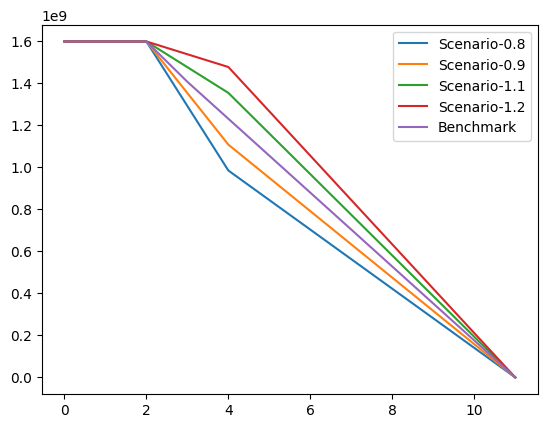

In [269]:
amortScenariosDf.plot()

In [270]:
ds = [_[0] for _ in amortSchedule ]
amortScheduleMap = tz.valmap(lambda v: list(zip(ds,v))
                            ,amortScenariosDf.to_dict(orient='list'))
amortScheduleMap['Scenario-0.8']

[('2024-09-26', 1600000000.0),
 ('2024-10-26', 1600000000.0),
 ('2024-11-26', 1600000000.0),
 ('2024-12-26', 1292800000.0),
 ('2025-01-26', 985600000.0000001),
 ('2025-02-26', 844800000.0),
 ('2025-03-26', 704000000.0000001),
 ('2025-04-26', 563200000.0),
 ('2025-05-26', 422400000.0),
 ('2025-06-26', 281600000.0),
 ('2025-07-26', 140800000.0),
 ('2025-08-26', 0.0)]

In [263]:
dealMap = tz.valmap(lambda x: JSD_AUTO_2024_2 & lens.债券[0][1]['债券类型']['固定摊还'].set(x), amortScheduleMap)

In [292]:
rMap = localAPI.runStructs(dealMap
                ,poolAssump=myAssumption
                 ,runAssump=[("revolving"
                                ,["constant",revol_asset]
                                ,("Pool",("Mortgage",None,None,None,None)
                                          ,None
                                          ,None))
                            ,("pricing",{"date":"2024-08-09"
                                       ,"curve":[["2024-04-09",0.03]]})
                            ,("call",{"poolFactor":0.10})
                            ]
                ,read=True)

通过一些查询，我们可以观察到，如果摊还比例越高，那么WAL月底，因为本金在相同时间区间内更快得得到偿付，相反，低摊还比例将会推高债券的期限溢价。

In [293]:
rMap['Benchmark']['result']['logs']

In [266]:
tz.pipe(tz.valmap(lambda x: x & lens["pricing"]['summary'].F(lambda p:p.loc['优先A1']).get(), rMap)
        ,lambda xm : pd.DataFrame(data=xm)
       )

,Benchmark,Scenario-0.8,Scenario-0.9,Scenario-1.1,Scenario-1.2
估值,1590020276.260,1590724224.590,1590414661.660,1589613967.410,1589213620.270
票面估值,99.376,99.420,99.401,99.351,99.326
WAL,0.700,0.650,0.680,0.730,0.760
久期,0.620,0.580,0.570,0.640,0.700
凸性,1.170,1.060,1.110,1.230,1.300
应计利息,0.000,0.000,0.000,0.000,0.000


In [272]:
import numpy as np

tz.pipe(tz.valmap(lambda x: x & lens["bonds"]['优先A1'].F(lambda y: y['cash'].sum()).get(), rMap)
        ,lambda m : pd.Series(data=m)
        ,lambda r : pd.DataFrame(data=r,columns=["Total Cash"])
        ,lambda df : df.assign(Average=np.nan).fillna(df['Total Cash'].mean())
        ,lambda df : df.assign(Pct=(df['Total Cash']-df['Average'])/df['Average'])
       )

,Total Cash,Average,Pct
Benchmark,1623512477.75,1623566638.42,-0.00
Scenario-0.8,1621839636.15,1623566638.42,-0.00
Scenario-0.9,1622575816.93,1623566638.42,-0.00
Scenario-1.1,1624477267.90,1623566638.42,0.00
Scenario-1.2,1625427993.37,1623566638.42,0.00


除了时间之外,我们观察不同场景下优先级的现金回款区别并不大,差别甚至不到0.3%, 原因在于：
* A1固定摊还期限仅不足一年
* A1利率本身较低

因此摊还节奏的变化对整体现金流的影响较小。

#### 注意



In [277]:
from absbox import flow_by_scenario

flow_by_scenario(rMap,["bonds","优先A1","principal"])

,Benchmark,Scenario-0.8,Scenario-0.9,Scenario-1.1,Scenario-1.2
date,,,,,
2024-09-26,0,0.00,0,0,0
2024-10-26,0,0.00,0,0,0
2024-11-26,0,0.00,0,0,0
2024-12-26,192000000,269117530.22,245600000,122400000,60800000
2025-01-26,176000000,261331559.77,245600000,122400000,60800000
2025-02-26,176000000,224750910.01,158400000,193600000,211200000
2025-03-26,176000000,140800000.00,158400000,193600000,211200000
2025-04-26,176000000,140800000.00,158400000,193600000,211200000
2025-05-26,176000000,140800000.00,158400000,193600000,211200000


In [274]:
from absbox import flow_by_scenario

flow_by_scenario(rMap,["bonds","优先A2","principal"])

,Benchmark,Scenario-0.8,Scenario-0.9,Scenario-1.1,Scenario-1.2
date,,,,,
2024-09-26,0.00,0.00,0.00,0.00,0.00
2024-10-26,0.00,0.00,0.00,0.00,0.00
2024-11-26,0.00,0.00,0.00,0.00,0.00
2024-12-26,77117530.22,0.00,23517530.22,146717530.22,208317530.22
2025-01-26,85575208.89,0.00,15805862.25,139395106.77,201189729.01
2025-02-26,74013808.90,24929902.45,91349848.48,56640371.17,39285632.53
2025-03-26,69762128.31,104740918.83,87350016.71,52173974.49,34585953.38
2025-04-26,64806681.15,99898493.11,82353114.30,47260288.54,29713875.68
2025-05-26,67782785.93,102966495.15,85374542.60,50191058.33,32599316.16


,Total Cash,Average,Pct
0.6,"1,620,965,334.660","1,623,791,698.568",-0.002
0.8,"1,621,839,636.150","1,623,791,698.568",-0.001
1,"1,623,512,477.750","1,623,791,698.568",-0.000
1.2,"1,625,534,884.770","1,623,791,698.568",0.001
1.4,"1,627,106,159.510","1,623,791,698.568",0.002


目前为止，我们已经犯了一个情感世界里常见的错误：过度关注自己的内心世界，忽略了同伴的变化。我们过度关注了A1的相关指标，而忽略了A2在不同场景下的变化。这里我们同样观察WAL的变化，得知，如果在A1高摊还情况下， A2的WAL会变得更大。

In [278]:
tz.pipe(tz.valmap(lambda x: x & lens["pricing"]['summary'].F(lambda p:p.loc['优先A2']).get(), rMap)
        ,lambda xm : pd.DataFrame(data=xm)
       )

,Benchmark,Scenario-0.8,Scenario-0.9,Scenario-1.1,Scenario-1.2
估值,2461226952.26,2461259485.31,2461245177.02,2461208176.49,2461189676.22
票面估值,100.05,100.05,100.05,100.05,100.05
WAL,1.26,1.29,1.28,1.24,1.22
久期,0.97,1.04,1.00,0.99,0.94
凸性,2.80,2.87,2.84,2.76,2.72
应计利息,0.00,0.00,0.00,0.00,0.00


原因在于，在前期更多的现金流用于偿付A1的本金，因此用于偿付A2的本金变少，最后导致A2的回款变慢，WAL变得更长。因此两者存在非线性此消彼长的关系。这说明什么问题？ 说明爱是妥协 （升华+1, 格局+1）

In [282]:
corr = tz.pipe(tz.valmap(lambda x: x & lens["pricing"]['summary'].F(lambda p:(p.loc['优先A1']["WAL"],p.loc['优先A2']["WAL"])).get(), tz.dissoc(rMap,"Benchmark"))
        ,lambda xm : pd.DataFrame(data=xm).rename(index={0: 'Bond A1',1:"Bond A2"})
       )
corr

,Scenario-0.8,Scenario-0.9,Scenario-1.1,Scenario-1.2
Bond A1,0.65,0.68,0.73,0.76
Bond A2,1.29,1.28,1.24,1.22


Text(0.5, 1.0, "WAL of bonds vs 'Amortization Balance Stress' ")

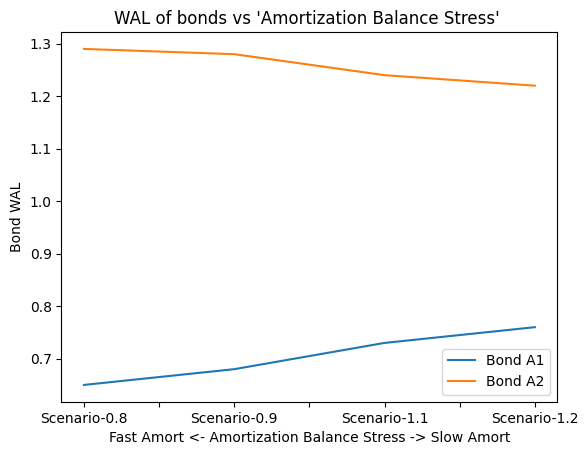

In [283]:
import matplotlib.pyplot as plt
corr.T.plot()
plt.xlabel('Fast Amort <- Amortization Balance Stress -> Slow Amort')
plt.ylabel('Bond WAL')
plt.title("WAL of bonds vs 'Amortization Balance Stress' ")

### 小结

* 产品设计的基础要求是资产和负债匹配, 可以通过现金流归集表对ABS产品进行匡算
* 固定摊还的交易安排如同跷跷板，WAL期限溢价在固定摊还债券和过手债券之间平衡
  * 如果固定摊还过于集中并且债券余额较大的情况下，可能存在流动性风险
  * 如果固定摊还较为平均，则WAL相对较小
  * 如果期限较短，利息较小情况下对债券现金流影响较小
  
